In [117]:
!pip install transformers


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [118]:
#!pip install accelerate

In [119]:
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [120]:
# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [121]:
def extract_features(text):
    # Tokenize the text and add special tokens for BERT
    input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True)).unsqueeze(0)
    # Encode the input tokens with BERT and get the hidden states
    outputs = model(input_ids)
    hidden_states = outputs.last_hidden_state
    # Apply max pooling to the hidden states to get a fixed-length representation of the text
    pooled = torch.max(hidden_states, 1)[0]
    return pooled.detach().numpy()

In [122]:
#import pandas as pd

#df = pd.read_csv('/content/drive/MyDrive/augmented_tweets.csv',engine="python",error_bad_lines=False)
df = pd.read_csv('../Datasets/restructured_data.csv',engine="python",error_bad_lines=False)

C:\Users\vikhy\AppData\Local\Temp\ipykernel_16528\3983080961.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('../Datasets/restructured_data.csv',engine="python",error_bad_lines=False)


In [123]:
print(df.head())

                                                Data   Stance
0  dear lord thank u for all of ur blessing forgi...  AGAINST
1  Blessed are the peacemaker for they shall be c...  AGAINST
2  I am not conformed to this world I am transfor...  AGAINST
3  salad should be prayed with focus and understa...  AGAINST
4  And stay in your house and do not display ours...  AGAINST


In [124]:
#df['text'] = df['target'] + ' ' + df['extended_target'] + ' ' + df['target_defintion'] + ' ' + df['tweets'] + ' ' + df['reformulated_tweets']
df['text'] = df['Data']

In [125]:
print(df['text'])

0       dear lord thank u for all of ur blessing forgi...
1       Blessed are the peacemaker for they shall be c...
2       I am not conformed to this world I am transfor...
3       salad should be prayed with focus and understa...
4       And stay in your house and do not display ours...
                              ...                        
3258    Ok he doe n't look like a mexican anymore but ...
3259    Look around this crowd We are young old We are...
3260    King Charles slavery research is not even bett...
3261    In The Passion Of The Christ 2 Jesus get raped...
3262    Congratulations 12yearsaslave Go to Africa or ...
Name: text, Length: 3263, dtype: object


In [126]:
# inputs = tokenizer(df['text'].tolist(), return_tensors='pt', padding=True, truncation=True)

# # Apply BERT to the input tensors and get the hidden states
# with torch.no_grad():
#     outputs = model(**inputs)

# # Get the hidden states tensor
# hidden_states = outputs.last_hidden_state

# # Apply max pooling to the hidden states to get a fixed-length representation of the input text
# pooled = torch.max(hidden_states, 1)[0]

# # Convert the pooled tensor to a numpy array
# features = pooled.numpy()

In [127]:
features = [extract_features(text) for text in df['text']]

In [128]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

In [129]:
print(len(features[3]))

1


In [130]:
X = np.array(features).reshape(len(features), -1)

In [131]:
# nsamples, nx, ny = features.shape
# new_features = features.reshape((nsamples,nx*ny))

In [132]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df.Stance)
df['categorical_label'] = le.transform(df.Stance)

In [133]:
print(df['categorical_label'].unique())
print(le.classes_)

[0 1 2]
['AGAINST' 'FAVOR' 'NONE']


In [134]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, df['categorical_label'], test_size=0.2, random_state=42)

# Train an SVM classifier on the features
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5359877488514548


In [136]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.69      0.65       317
           1       0.43      0.37      0.40       169
           2       0.46      0.41      0.43       167

    accuracy                           0.54       653
   macro avg       0.50      0.49      0.49       653
weighted avg       0.53      0.54      0.53       653



In [137]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.496 total time=   1.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.498 total time=   1.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.496 total time=   1.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.496 total time=   1.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.496 total time=   2.7s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.556 total time=   2.6s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.552 total time=   2.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.546 total time=   2.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.559 total time=   2.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.567 total time=   1.9s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.554 total time=   1.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [138]:

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, gamma=0.01)


In [139]:

grid_predictions = grid.predict(X_test)
  
# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70       317
           1       0.59      0.47      0.52       169
           2       0.55      0.49      0.52       167

    accuracy                           0.62       653
   macro avg       0.60      0.57      0.58       653
weighted avg       0.61      0.62      0.61       653



In [140]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=grid_predictions)
# cm = np.delete(cm, obj=3, axis=1)
# cm = np.delete(cm, obj=3, axis=0)
print(cm)

[[242  35  40]
 [ 64  79  26]
 [ 66  19  82]]


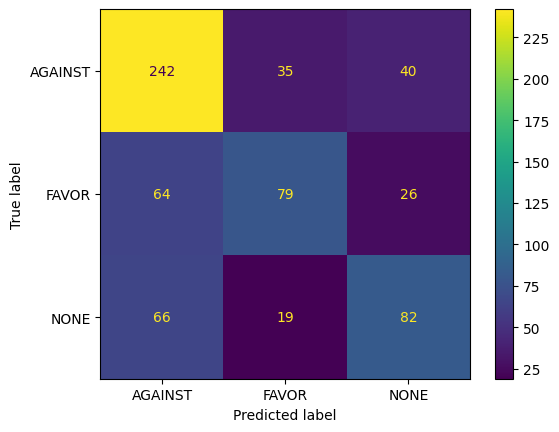

In [141]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["AGAINST","FAVOR","NONE"])
disp.plot()

In [142]:
print("Accuracy: ",accuracy_score(y_test, grid_predictions))
print("Recall Score: ",recall_score(y_test, grid_predictions, average='weighted'))
print("Precision Score: ",precision_score(y_test, grid_predictions, average='weighted'))
print("F1 Score: ",f1_score(y_test, grid_predictions, average='weighted'))

Accuracy:  0.6171516079632465
Recall Score:  0.6171516079632465
Precision Score:  0.6112265172759119
F1 Score:  0.6095641628326443


In [143]:
import pickle

with open('BERT_SVM_model_restructured.pkl','wb') as f:
    pickle.dump(grid,f)